## OGT phenotype: data analysis, processing, and visualization

#### 1. Read the train and test datasets and plot a histogram

Number of categories = 35
min temp = 5.5
max temp = 104.5


Text(0, 0.5, 'counts')

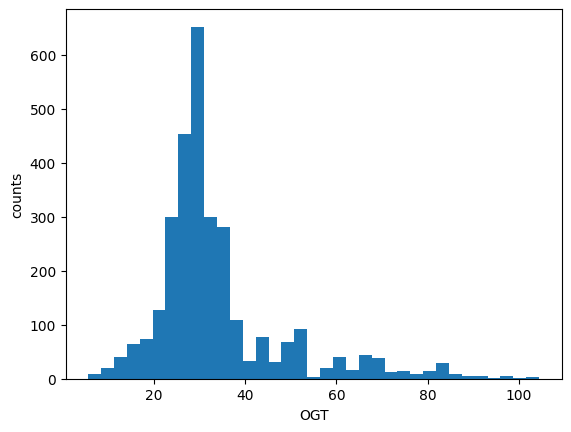

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys

# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from set_transformer.main import read_ogt_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 35 

ogt_continuous_flag = False
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag)

print(f"Number of categories = {num_classes}")

y_train_to_temp = []
for categ_i in y_train.tolist():
    categ_i = int(categ_i)
    mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
    y_train_to_temp.append(mid_bin_temp)

print(f"min temp = {min(y_train_to_temp)}")
print(f"max temp = {max(y_train_to_temp)}")
hist = plt.hist(y_train_to_temp, bins = num_classes)
plt.xlabel("OGT")
plt.ylabel("counts")

#### 2. Read and plot results of training

In this section, we plot the results for SetTransformers trained for the OGT data. In particular, we visualize the cross-validation predictions for different folds.

The results are visualized for a specified value of the number  of inducing points.

In [10]:
# Axillary function for reading the data 
def read_and_plot(filename, plot_flag=False):
    directory = "../results/SetTransformer/ogt/discrete_predict"
    df = pd.read_csv(f"{directory}/{filename}.csv",sep="\t")  # Replace with your file path
    
    y_act_to_temp = []
    for categ_i in df['y_actual']:
        mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
        y_act_to_temp.append(mid_bin_temp)
    predict_to_temp = []
    for categ_i in df['prediction']:
        mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
        predict_to_temp.append(mid_bin_temp)
    if plot_flag:
        plt.scatter(y_act_to_temp, predict_to_temp, marker='o', alpha = 0.3, c = "tab:blue", s=13)
    return min(y_act_to_temp), max(y_act_to_temp), min(predict_to_temp), max(predict_to_temp), y_act_to_temp, predict_to_temp

In [57]:
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


# Specify the number of inducing points for plotting the results 
ind_point = 4
folds = range(5) # specify the fold range for data
file_names_cv = [f"prediction_probabilities_cross_valid_fold_{fold}_SetTransformer_indPoints_{ind_point}" for fold in folds]

# Read the actual OGT and the predicted classes + transform the classes to the temperature
y_act_to_temp_tot = []
predict_to_temp_tot = []
for file in file_names_cv:
    x_min, x_max, y_min, y_max, y_act_to_temp, predict_to_temp = read_and_plot(file, plot_flag=False)
    y_act_to_temp_tot += y_act_to_temp
    predict_to_temp_tot += predict_to_temp

In [58]:
# Calculate R^2 and pearson correlation coefficient
r2 = r2_score(y_act_to_temp_tot, predict_to_temp_tot)
print(f"R^2 = {round(r2,2)}")

pcc_scipy, p_value = pearsonr(y_act_to_temp_tot, predict_to_temp_tot)
print(f"PCC = {round(pcc_scipy,2)}")

R^2 = 0.71
PCC = 0.86


In [59]:
# Fit a linear regression model
model = LinearRegression()

x = np.array(y_act_to_temp_tot).reshape(-1, 1)
y = np.array(predict_to_temp_tot)
model.fit(x, y)

# Get predictions for the best-fit line
y_pred = model.predict(x)

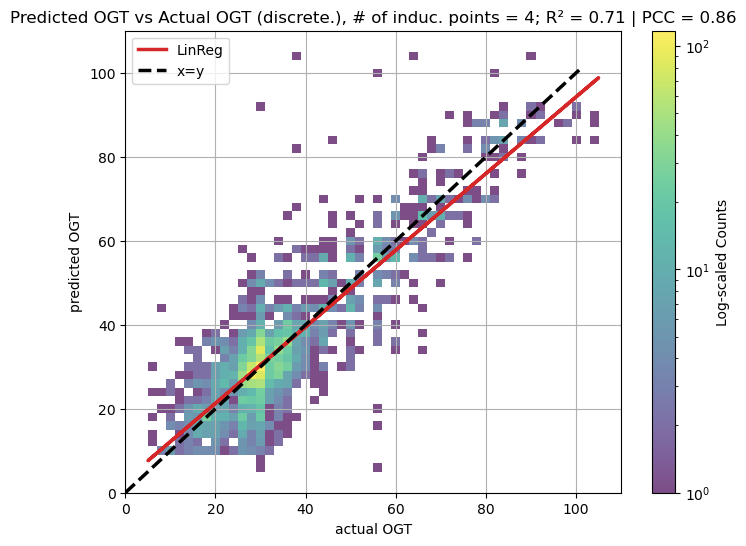

In [84]:
# Create the figure
plt.figure(figsize=(8, 6))
plt.grid(True)

# Plot the best-fit line
plt.plot(x, y_pred, color='tab:red', linewidth=2.5, label=f'LinReg')

# Create a 2D histogram with log scaling for counts
hist = plt.hist2d(
    y_act_to_temp_tot,
    predict_to_temp_tot,
    bins=num_classes,
    norm=LogNorm(),
    cmap='viridis', alpha = 0.7
)
plt.plot([0,x_max],[0,x_max], c = "black", label = "x=y", linestyle='--', linewidth=2.5)
plt.xlim([0,110])
plt.ylim([0,110])

# Add a color bar with the label
cbar = plt.colorbar(hist[3], label="Log-scaled Counts")

# Add labels and a title
plt.title(f'Predicted OGT vs Actual OGT (discrete.), # of induc. points = {ind_point}; R² = {round(r2,2)} | PCC = {round(pcc_scipy,2)}')
plt.xlabel('actual OGT')
plt.ylabel('predicted OGT')
plt.legend()
# Show the plot
plt.show()

#### 3. Plot the model accuracy as the function of the number of inducing points

(0.4, 0.8)

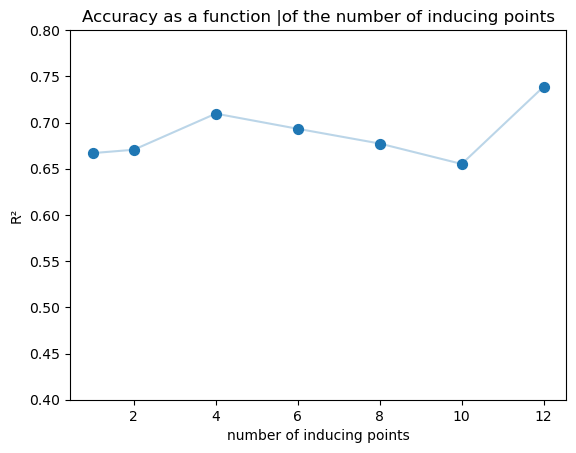

In [87]:
num_ind_arr = [1, 2, 4, 6, 8, 10, 12]#, 6, 8, 10, 12, 14, 16, 18, 20]#[1, 2, 4, 6, 8, 10, 12, 14, 16, 18]
r2_arr = []

file_names_cv_arr = []
for ind_point in num_ind_arr:
    file_names_cv = [f"prediction_probabilities_cross_valid_fold_0_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_1_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_2_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_3_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_4_SetTransformer_indPoints_{ind_point}"]
    y_act_to_temp_tot = []
    predict_to_temp_tot = []
    for file in file_names_cv:
        x_min, x_max, y_min, y_max, y_act_to_temp, predict_to_temp = read_and_plot(file)
        y_act_to_temp_tot += y_act_to_temp
        predict_to_temp_tot += predict_to_temp
    r2 = r2_score(y_act_to_temp_tot, predict_to_temp_tot)
    r2_arr.append(r2)

plt.figure()
plt.scatter(num_ind_arr, r2_arr, s=50)
plt.plot(num_ind_arr, r2_arr, alpha = 0.3)
plt.xlabel("number of inducing points")
plt.ylabel("R²")
plt.title("Accuracy as a function |of the number of inducing points")
plt.ylim([0.4,0.8])

#### 4. PCA visualization of the initial data (colors = temperature)

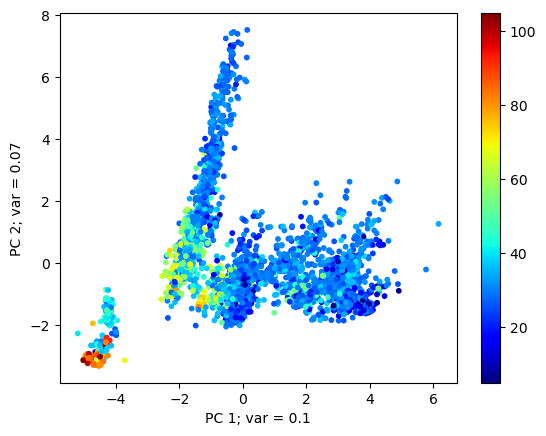

In [13]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

n_compon=2
# Run PCA on the X-data
pca = PCA(n_components=n_compon)
X_train_pca = pca.fit_transform(X_train)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure()
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=1, s = 10, c=y_train_to_temp, cmap='jet')
plt.xlabel(f"PC 1; var = {round(explained_variance_ratio[0],2)}")
plt.ylabel(f"PC 2; var = {round(explained_variance_ratio[1],2)}")
plt.colorbar()

#### 5. tSNE visualization of the initial data (colors = temperature)

In [142]:
from sklearn.manifold import TSNE

# Initialize and apply t-SNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, max_iter=3000, init='pca') 
X_tsne = tsne.fit_transform(X_train) 

print(X_tsne.shape)

(3001, 2)


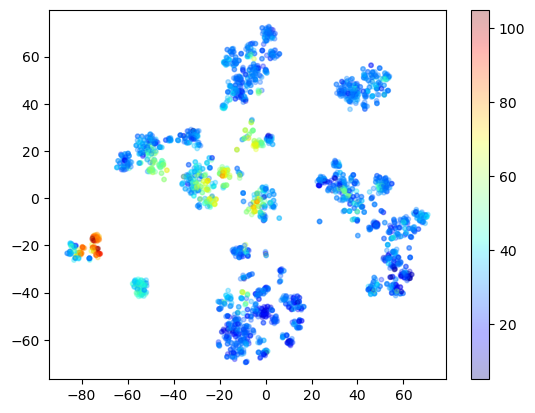

In [143]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.3, s = 10, c=y_train_to_temp, cmap='jet')
plt.colorbar()

Text(0.5, 1.0, 'Predicted OGT vs Actual OGT (continuous), # of induc. points = 4; MSE = 38.43; RMSE = 6.2')

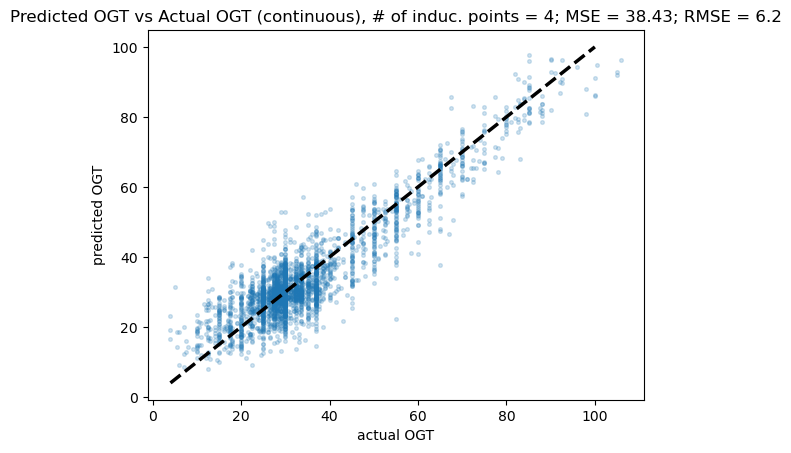

In [83]:
# Specify the number of inducing points for plotting the results 
ind_point = 4
folds = range(5) # specify the fold range for data
file_names_cv = [f"prediction_probabilities_cross_valid_fold_{fold}_SetTransformer_indPoints_{ind_point}" for fold in folds]


directory = "../results/SetTransformer/ogt/continuous_predict"

y_actual_total = []
y_predict_total = []
for filename in file_names_cv:
    df = pd.read_csv(f"{directory}/{filename}.csv",sep="\t") 
    y_actual = df["y_actual"].tolist()
    y_predict = df["prediction"].tolist()
    
    y_actual_total += y_actual
    y_predict_total += y_predict

mse = np.mean((np.array(y_actual_total) - np.array(y_predict_total)) ** 2)
    
plt.scatter(y_actual_total, y_predict_total, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5)    
plt.xlabel('actual OGT')
plt.ylabel('predicted OGT')    
plt.title(f'Predicted OGT vs Actual OGT (contin.), # of induc. points = {ind_point}; MSE = {round(mse,2)}; RMSE = {round(np.sqrt(mse),2)}')

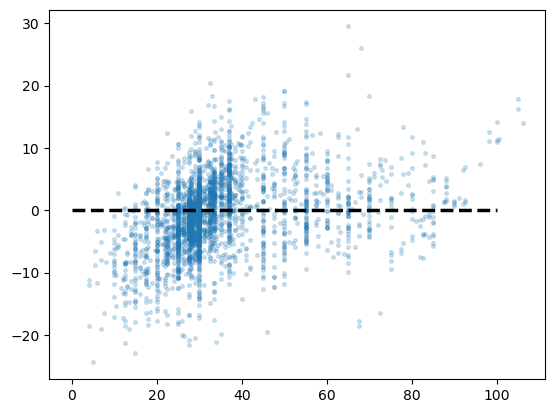

In [77]:
diff = []
for i in range(len(y_actual_total)):
    diff.append(y_actual_total[i] -  y_predict_total[i])
plt.scatter(y_actual_total, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7)    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5)    

(25.0, 50.0)

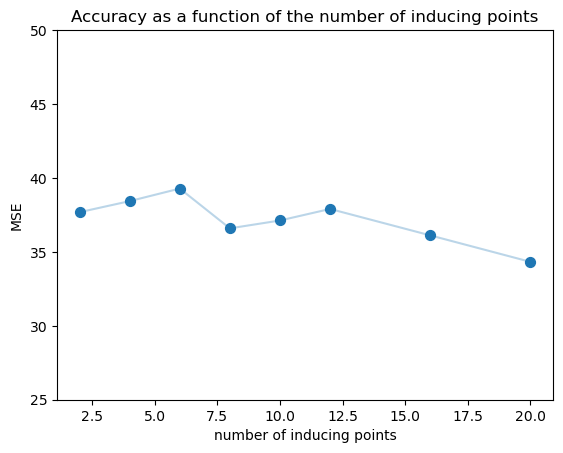

In [79]:
num_ind_arr = [2, 4, 6, 8, 10, 12, 16, 20]#[1, 2, 4, 6, 8, 10, 12, 14, 16, 18]
mse_arr = []
folds = range(5)
directory = "../results/SetTransformer/ogt/continuous_predict"

file_names_cv_arr = []
for ind_point in num_ind_arr:
    file_names_cv = [f"prediction_probabilities_cross_valid_fold_{fold}_SetTransformer_indPoints_{ind_point}" for fold in folds]
  #  print(file_names_cv)
    y_actual_total = []
    y_predict_total = []
    for file in file_names_cv:
        #print(f"{directory}/{file}.csv")
        df = pd.read_csv(f"{directory}/{file}.csv",sep="\t") 
       # print(df)
        y_actual = df["y_actual"].tolist()
        y_predict = df["prediction"].tolist()
        
        y_actual_total += y_actual
        y_predict_total += y_predict
    mse = np.mean((np.array(y_actual_total) - np.array(y_predict_total)) ** 2)
    mse_arr.append(mse)

plt.figure()
plt.scatter(num_ind_arr, mse_arr, s=50)
plt.plot(num_ind_arr, mse_arr, alpha = 0.3)
plt.xlabel("number of inducing points")
plt.ylabel("MSE")
plt.title("Accuracy as a function of the number of inducing points")
plt.ylim([25,50])

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import mutual_info_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [34]:
#Add XGBoost
ogt_continuous_flag = True
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag)

print(np.unique(y_train.cpu().numpy()))
print(len(np.unique(y_train.cpu().numpy())))
print(np.unique(y_test.cpu().numpy()))

[  4.         5.         5.5        6.         7.         7.5
   8.         9.        10.        10.5       11.        11.5
  12.        12.5       13.        13.5       14.        14.5
  15.        16.        16.5       17.        17.5       18.
  18.5       19.        19.5       20.        20.5       21.
  21.5       22.        22.5       22.666666  23.        23.4
  23.5       24.        24.25      24.333334  24.5       25.
  25.5       25.75      26.        26.333334  26.5       27.
  27.25      27.5       27.666666  27.75      28.        28.25
  28.333334  28.5       28.666666  28.75      29.        29.5
  30.        30.5       30.75      31.        31.25      31.5
  31.666666  32.        32.5       33.        33.5       33.8
  34.        34.5       35.        35.5       35.666668  36.
  36.5       37.        37.5       38.        38.5       38.75
  39.        39.5       40.        40.5       41.        41.5
  42.        42.5       43.        43.5       44.        45.
  45.5      

In [35]:
pipe = make_pipeline(MaxAbsScaler(), XGBClassifier(n_jobs=THREADS if device == "cpu" else None, tree_method="gpu_hist" if device == "cpu" else "hist"))
pipe.fit(X_train.cpu(), y_train.cpu().numpy());

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161], got [  4.         5.         5.5        6.         7.         7.5
   8.         9.        10.        10.5       11.        11.5
  12.        12.5       13.        13.5       14.        14.5
  15.        16.        16.5       17.        17.5       18.
  18.5       19.        19.5       20.        20.5       21.
  21.5       22.        22.5       22.666666  23.        23.4
  23.5       24.        24.25      24.333334  24.5       25.
  25.5       25.75      26.        26.333334  26.5       27.
  27.25      27.5       27.666666  27.75      28.        28.25
  28.333334  28.5       28.666666  28.75      29.        29.5
  30.        30.5       30.75      31.        31.25      31.5
  31.666666  32.        32.5       33.        33.5       33.8
  34.        34.5       35.        35.5       35.666668  36.
  36.5       37.        37.5       38.        38.5       38.75
  39.        39.5       40.        40.5       41.        41.5
  42.        42.5       43.        43.5       44.        45.
  45.5       46.        46.5       47.        47.5       48.
  49.        50.        50.5       51.        51.5       52.
  52.5       53.        54.        55.        56.        56.5
  57.        57.5       58.        58.5       59.        60.
  61.        61.5       62.5       63.        64.        65.
  66.        66.5       67.        67.5       68.        68.5
  70.        71.        72.        72.5       73.        73.75
  74.        75.        77.5       78.        79.        80.
  81.        82.        82.5       83.        84.        85.
  87.5       88.        90.        91.        92.        92.5
  96.        98.       100.       100.5      105.       106.      ]

In [23]:
train_accuracy = accuracy_score(y_train.cpu(), pipe.predict(X_train.cpu()))
test_accuracy = accuracy_score(y_test.cpu(), pipe.predict(X_test.cpu()))
print(f"train_accuracy = {train_accuracy}; test_accuracy = {test_accuracy}")

train_accuracy = 1.0; test_accuracy = 0.20239680426098536


In [24]:
y_pred = pipe.predict(X_test.cpu()) 

In [36]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
model = XGBRegressor(
    n_jobs=-1,                # Use all CPU cores
    tree_method="gpu_hist",   # Use "hist" for CPU, "gpu_hist" for GPU
    objective="reg:squarederror"  # Default loss function for regression
)

# Train the model
model.fit(X_train.cpu(), y_train.cpu().numpy())

# Make predictions
y_pred = model.predict(X_test.cpu())

# Evaluate using RMSE
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), y_pred))
print(f"RMSE: {rmse:.2f}")


C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:17:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


RMSE: 7.71


C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:17:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


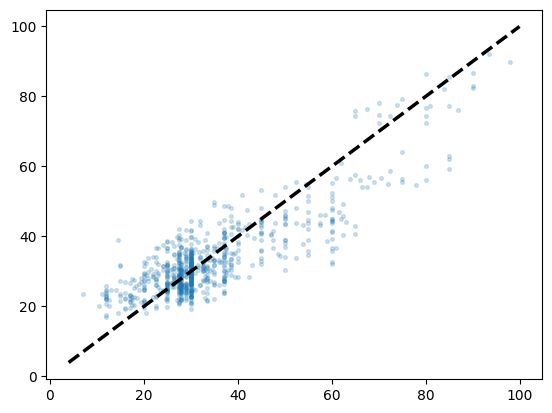

In [38]:
plt.scatter(y_test.cpu().numpy(),y_pred, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 